In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize
import shap

In [2]:
# Define dataset class
class ECGDataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path, header=None)
        self.signals = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
        self.labels = torch.tensor(data.iloc[:, -1].values, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]  # Remove unnecessary unsqueeze

In [3]:
# Load datasets
def get_dataloader(file_path, batch_size=32):
    dataset = ECGDataset(file_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_dataloader(r"C:\Users\Admin\Desktop\Projects - College\Medical Diagnosis using LNN (Major)\mitbih\mitbih_train.csv")
test_loader = get_dataloader(r"C:\Users\Admin\Desktop\Projects - College\Medical Diagnosis using LNN (Major)\mitbih\mitbih_test.csv")
abnormal_loader = get_dataloader(r"C:\Users\Admin\Desktop\Projects - College\Medical Diagnosis using LNN (Major)\mitbih\ptbdb_abnormal.csv")
normal_loader = get_dataloader(r"C:\Users\Admin\Desktop\Projects - College\Medical Diagnosis using LNN (Major)\mitbih\ptbdb_normal.csv")

# Define class labels
class_labels = {0: "Normal", 1: "Supraventricular", 2: "Ventricular", 3: "Fusion", 4: "Unknown"}

In [4]:
# Define Liquid Neural Network model
class LiquidECGClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidECGClassifier, self).__init__()
        self.liquid_layer = nn.RNN(input_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1, input_size)  # Ensure correct shape (batch, seq_len, input_size)
        x, _ = self.liquid_layer(x)
        x = self.fc(x[:, -1, :])  # Take last output for classification
        return x

In [5]:
# Model setup
input_size = 187  # Assuming ECG signals have 187 features
hidden_size = 128
output_size = len(set(pd.read_csv(r"C:\Users\Admin\Desktop\Projects - College\Medical Diagnosis using LNN (Major)\mitbih\mitbih_train.csv", header=None).iloc[:, -1]))  # Dynamically determine number of classes

model = LiquidECGClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def visualize_data(train_loader):
    samples = {label: None for label in class_labels.keys()}  # Store one sample per class
    
    for signals, labels in train_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if samples[label] is None:
                samples[label] = signals[i].numpy()
            if all(sample is not None for sample in samples.values()):  # Stop when all classes are represented
                break
        if all(sample is not None for sample in samples.values()):
            break
    
    plt.figure(figsize=(10, 6))
    for label, signal in samples.items():
        plt.plot(signal, label=f"Class {class_labels[label]}")
    plt.xlabel("Time Steps")
    plt.ylabel("ECG Signal Value")
    plt.title("Sample ECG Signals from Training Set")
    plt.legend()
    plt.savefig("Sample ECG Signals from Training Set.png", dpi=300, bbox_inches='tight')
    plt.show()

Epoch 1/10, Loss: 0.2970
Epoch 2/10, Loss: 0.1931
Epoch 3/10, Loss: 0.1642
Epoch 4/10, Loss: 0.1471
Epoch 5/10, Loss: 0.1337
Epoch 6/10, Loss: 0.1233
Epoch 7/10, Loss: 0.1144
Epoch 8/10, Loss: 0.1079
Epoch 9/10, Loss: 0.1022
Epoch 10/10, Loss: 0.0975


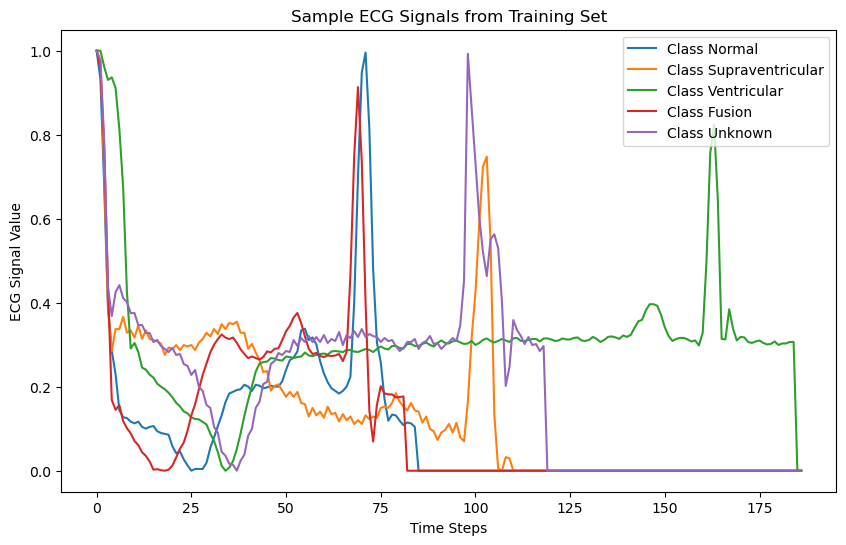

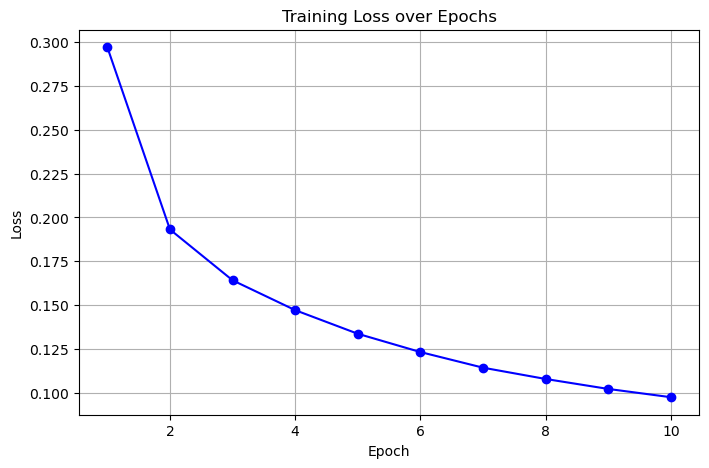

In [7]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for signals, labels in train_loader:
            signals = signals.view(signals.size(0), -1, input_size)
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    visualize_data(train_loader)
    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid()
    plt.savefig("Training Loss over Epochs.png", dpi=300, bbox_inches='tight')
    plt.show()
    
train_model(model, train_loader, criterion, optimizer)

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for signals, labels in test_loader:
            signals = signals.view(signals.size(0), -1, input_size)
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [9]:
def plot_roc_curve(model, test_loader, output_size):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for signals, labels in test_loader:
            signals = signals.view(signals.size(0), -1, input_size)
            outputs = model(signals)
            probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            all_labels.extend(labels.numpy())
            all_probs.extend(probabilities.numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_bin = label_binarize(all_labels, classes=np.arange(output_size))
    
    plt.figure(figsize=(10, 6))
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class ECG Classification')
    plt.legend()
    plt.grid()
    plt.savefig("ROC Curve for Multi-Class ECG Classification.png", dpi=300, bbox_inches='tight')
    plt.show()

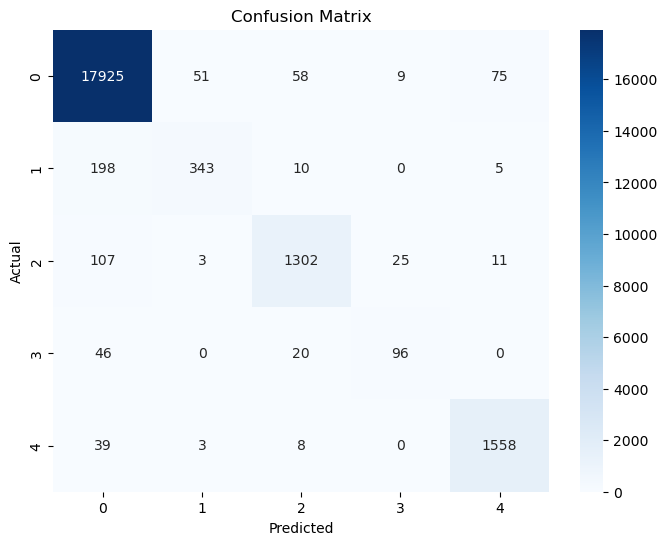

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18118
           1       0.86      0.62      0.72       556
           2       0.93      0.90      0.91      1448
           3       0.74      0.59      0.66       162
           4       0.94      0.97      0.96      1608

    accuracy                           0.97     21892
   macro avg       0.89      0.81      0.85     21892
weighted avg       0.97      0.97      0.97     21892

Test Accuracy: 96.95%


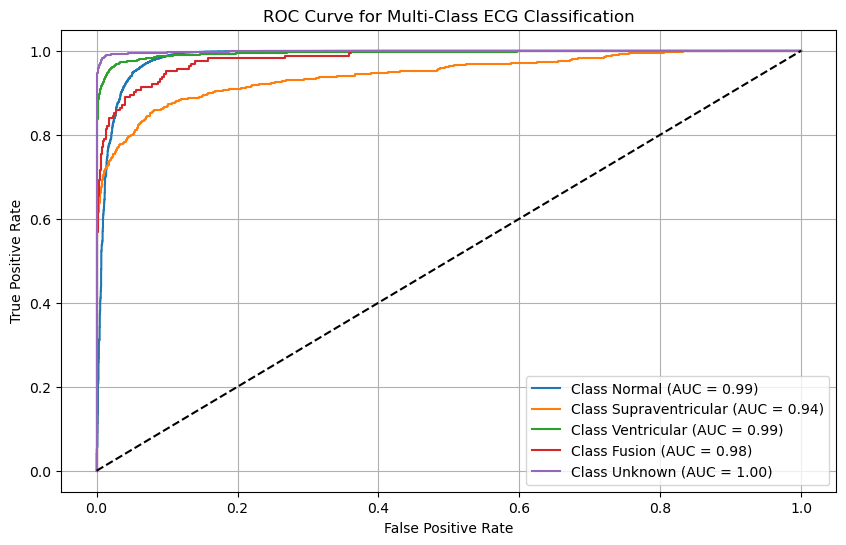

In [10]:
evaluate_model(model, test_loader)
plot_roc_curve(model, test_loader, output_size)

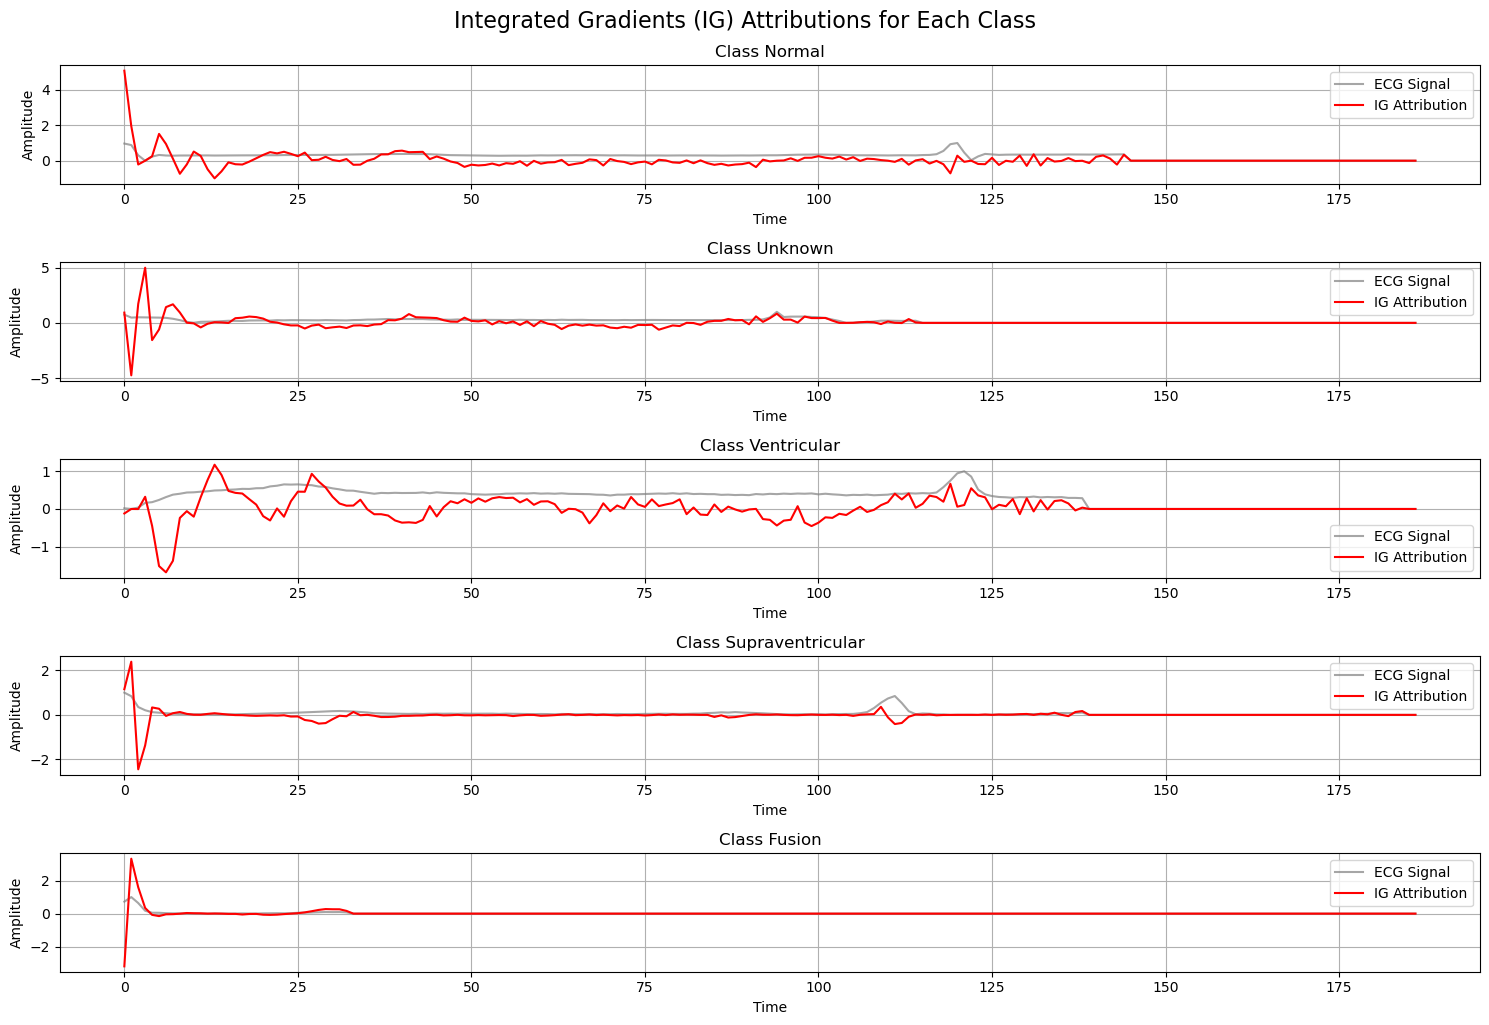

In [11]:
from captum.attr import IntegratedGradients
import torch.nn.functional as F

# Step 1: Wrap your model
class WrappedECGModel(nn.Module):
    def __init__(self, model):
        super(WrappedECGModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = x.view(x.size(0), -1, input_size)  # Reshape for RNN input
        return self.model(x)

# Step 2: Initialize attribution method
wrapped_model = WrappedECGModel(model)
wrapped_model.eval()
ig = IntegratedGradients(wrapped_model)

# Step 3: Helper function to compute and plot IG for each class
def plot_ig_for_each_class(test_loader, class_labels, samples_per_class=1):
    plotted = {label: 0 for label in class_labels.keys()}  # track samples
    plt.figure(figsize=(15, 10))
    subplot_idx = 1

    for signals, labels in test_loader:
        for i in range(signals.size(0)):
            label = labels[i].item()
            if plotted[label] < samples_per_class:
                input_signal = signals[i].unsqueeze(0)
                target_class = label

                attributions, delta = ig.attribute(input_signal, target=target_class, return_convergence_delta=True)
                attr = attributions.squeeze().detach().numpy()
                signal = input_signal.squeeze().detach().numpy()

                # Plot
                plt.subplot(len(class_labels), samples_per_class, subplot_idx)
                plt.plot(signal, label="ECG Signal", color="gray", alpha=0.7)
                plt.plot(attr, label="IG Attribution", color="red")
                plt.title(f"Class {class_labels[target_class]}")
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid()
                subplot_idx += 1

                plotted[label] += 1
            if all(v >= samples_per_class for v in plotted.values()):
                break
        if all(v >= samples_per_class for v in plotted.values()):
            break

    plt.tight_layout()
    plt.suptitle("Integrated Gradients (IG) Attributions for Each Class", fontsize=16, y=1.02)
    plt.savefig("Integrated Gradients (IG) Attributions for Each Class.png", dpi=300, bbox_inches='tight')
    plt.show()

# Step 4: Call function to plot
plot_ig_for_each_class(test_loader, class_labels, samples_per_class=1)

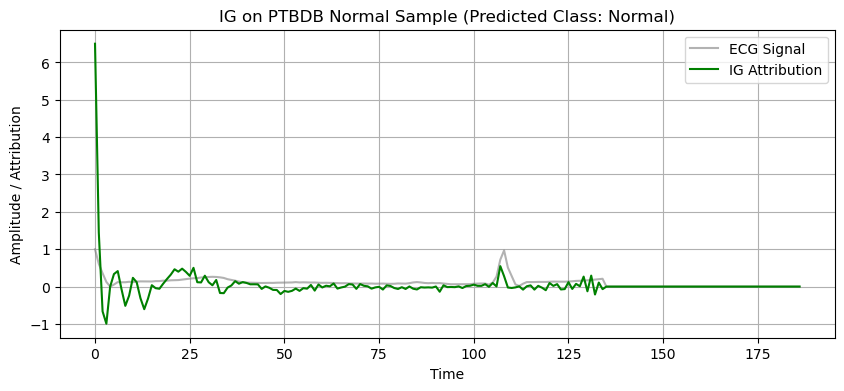

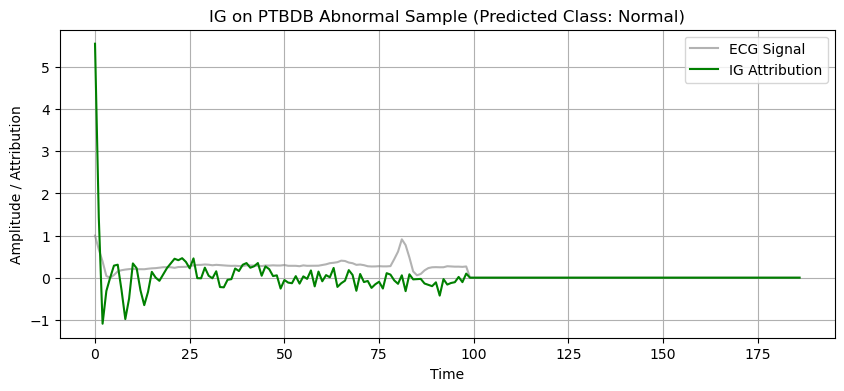

In [26]:
def plot_ig_ptbdb_samples(model, loader, title_suffix=""):
    wrapped_model = WrappedECGModel(model)
    wrapped_model.eval()
    ig = IntegratedGradients(wrapped_model)

    for signals, labels in loader:
        input_signal = signals[0].unsqueeze(0)
        target_class = model(input_signal.view(1, -1, input_size)).argmax(dim=1).item()
        attributions, delta = ig.attribute(input_signal, target=target_class, return_convergence_delta=True)
        attr = attributions.squeeze().detach().numpy()
        signal = input_signal.squeeze().detach().numpy()

        # Plot and save
        plt.figure(figsize=(10, 4))
        plt.plot(signal, label="ECG Signal", color="gray", alpha=0.6)
        plt.plot(attr, label="IG Attribution", color="green")
        plt.title(f"IG on PTBDB {title_suffix} Sample (Predicted Class: {class_labels.get(target_class, target_class)})")
        plt.xlabel("Time")
        plt.ylabel("Amplitude / Attribution")
        plt.legend()
        plt.grid()
        
        # Save file with a unique name
        filename = f"IG_PTDB_{title_suffix}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        break  # only 1 sample

# Plot IG on PTBDB datasets
plot_ig_ptbdb_samples(model, normal_loader, "Normal")
plot_ig_ptbdb_samples(model, abnormal_loader, "Abnormal")


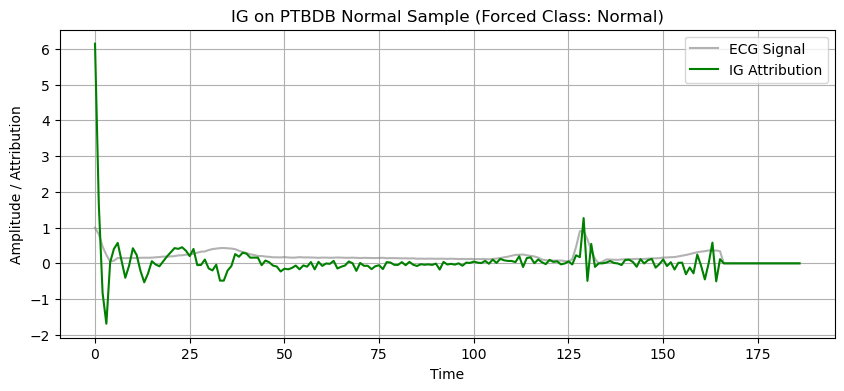

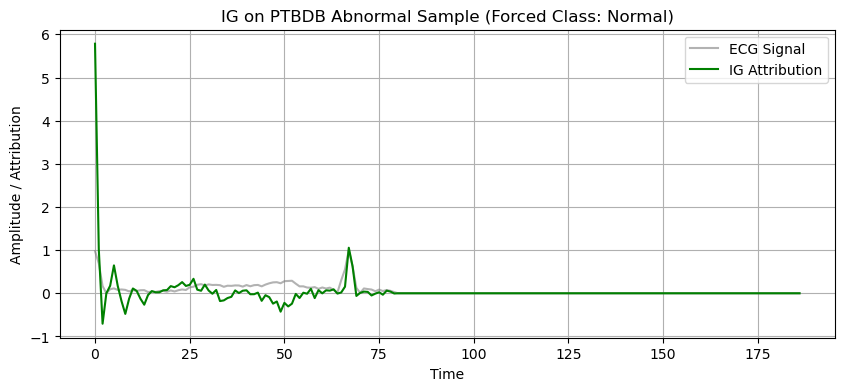

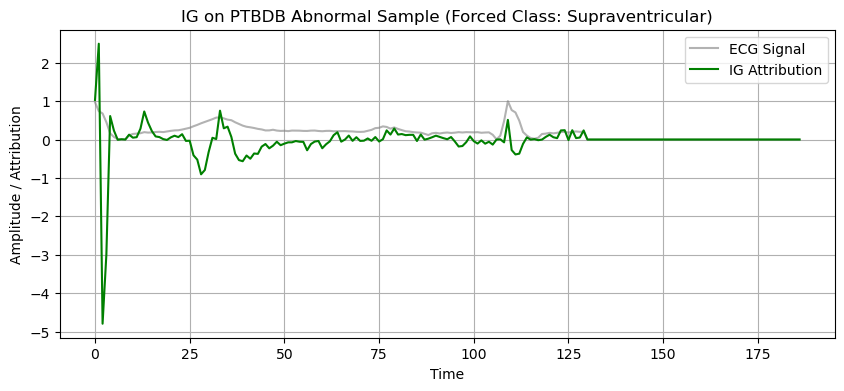

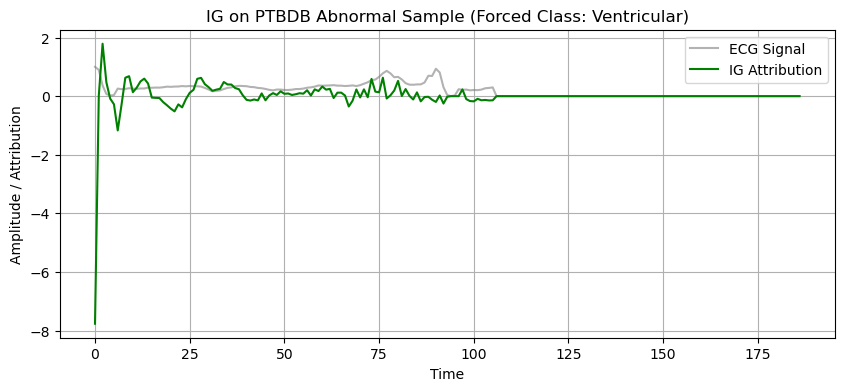

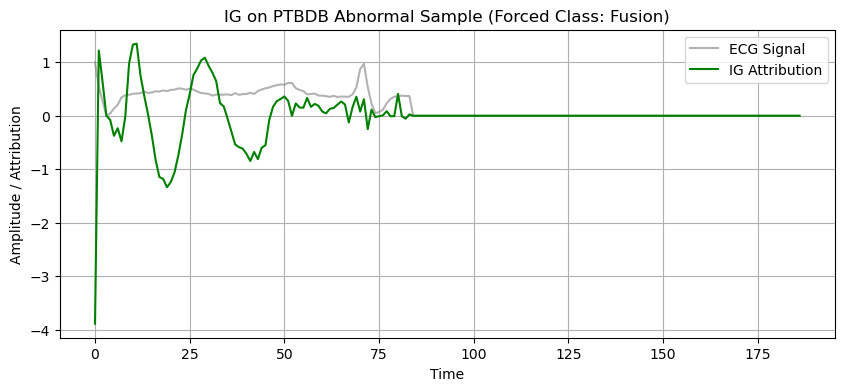

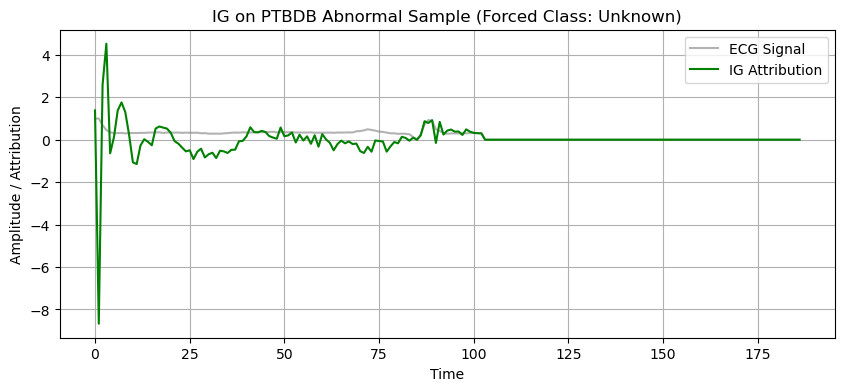

In [30]:
def plot_ig_ptbdb_samples(model, loader, title_suffix="", forced_class=None):
    wrapped_model = WrappedECGModel(model)
    wrapped_model.eval()
    ig = IntegratedGradients(wrapped_model)

    for signals, labels in loader:
        input_signal = signals[0].unsqueeze(0)

        # 👇 Use forced class if specified, else use predicted class
        if forced_class is not None:
            target_class = forced_class
        else:
            output = model(input_signal.view(1, -1, input_size))
            target_class = output.argmax(dim=1).item()

        # Compute IG
        attributions, delta = ig.attribute(input_signal, target=target_class, return_convergence_delta=True)
        attr = attributions.squeeze().detach().numpy()
        signal = input_signal.squeeze().detach().numpy()

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(signal, label="ECG Signal", color="gray", alpha=0.6)
        plt.plot(attr, label="IG Attribution", color="green")
        class_label = class_labels.get(target_class, f"Class {target_class}")
        plt.title(f"IG on PTBDB {title_suffix} Sample (Forced Class: {class_label})")
        plt.xlabel("Time")
        plt.ylabel("Amplitude / Attribution")
        plt.legend()
        plt.grid()

        # Save figure with class name
        filename = f"IG_PTDB_{title_suffix}_forced_{class_label}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        break  # Only 1 sample

plot_ig_ptbdb_samples(model, normal_loader, "Normal")
# Force each class for the same abnormal sample
for cls_id in range(5):
    plot_ig_ptbdb_samples(model, abnormal_loader, title_suffix="Abnormal", forced_class=cls_id)


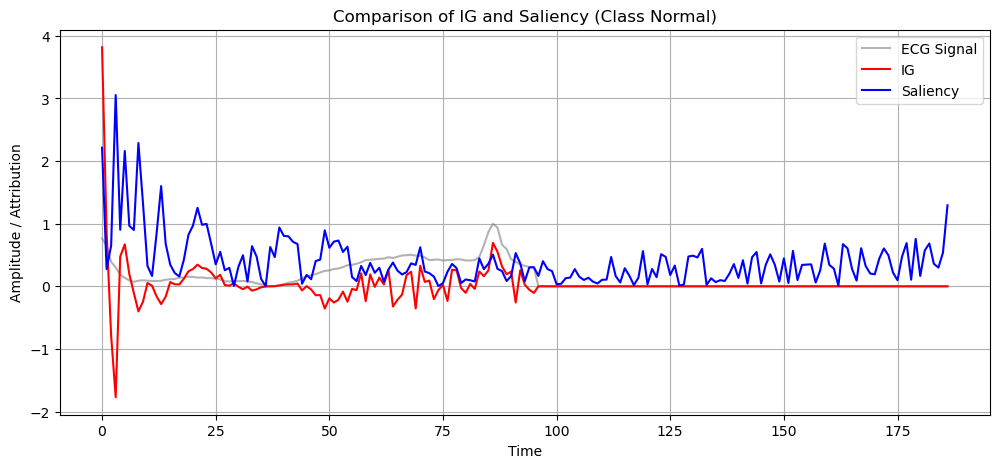

In [16]:
from captum.attr import Saliency

def compare_saliency_vs_ig(model, loader, class_labels):
    wrapped_model = WrappedECGModel(model)
    wrapped_model.eval()
    ig = IntegratedGradients(wrapped_model)
    sal = Saliency(wrapped_model)

    for signals, labels in loader:
        input_signal = signals[0].unsqueeze(0).requires_grad_()  # FIXED
        target_class = labels[0].item()

        ig_attr, _ = ig.attribute(input_signal, target=target_class, return_convergence_delta=True)
        sal_attr = sal.attribute(input_signal, target=target_class)

        ig_attr = ig_attr.squeeze().detach().numpy()
        sal_attr = sal_attr.squeeze().detach().numpy()
        signal = input_signal.squeeze().detach().numpy()

        # Plot comparison
        plt.figure(figsize=(12, 5))
        plt.plot(signal, label="ECG Signal", color="gray", alpha=0.6)
        plt.plot(ig_attr, label="IG", color="red")
        plt.plot(sal_attr, label="Saliency", color="blue")
        plt.title(f"Comparison of IG and Saliency (Class {class_labels[target_class]})")
        plt.xlabel("Time")
        plt.ylabel("Amplitude / Attribution")
        plt.legend()
        plt.grid()
        plt.savefig("Comparison of IG and Saliency.png", dpi=300, bbox_inches='tight')
        plt.show()
        break  # only 1 example

compare_saliency_vs_ig(model, test_loader, class_labels)

In [18]:
def summarize_ig_attributions(model, loader, class_labels, min_samples=5):
    wrapped_model = WrappedECGModel(model)
    wrapped_model.eval()
    ig = IntegratedGradients(wrapped_model)

    attr_summary = {label: [] for label in class_labels.keys()}
    collected = {label: 0 for label in class_labels.keys()}

    for signals, labels in loader:
        for i in range(signals.size(0)):
            label = labels[i].item()
            if collected[label] < min_samples:
                input_signal = signals[i].unsqueeze(0)
                attributions, _ = ig.attribute(input_signal, target=label, return_convergence_delta=True)
                attr = attributions.squeeze().detach().numpy()
                attr_summary[label].append(np.mean(np.abs(attr)))
                collected[label] += 1
        if all(count >= min_samples for count in collected.values()):
            break

    summary_df = pd.DataFrame({
        "Class": [class_labels[i] for i in attr_summary.keys()],
        "Mean IG Attribution": [np.mean(attr_summary[i]) if attr_summary[i] else float('nan') for i in attr_summary.keys()],
        "Std Dev": [np.std(attr_summary[i]) if attr_summary[i] else float('nan') for i in attr_summary.keys()],
    })

    print("\n Attribution Summary Table:")
    print(summary_df.to_string(index=False))
    return summary_df

summary_df = summarize_ig_attributions(model, test_loader, class_labels, min_samples=5)


 Attribution Summary Table:
           Class  Mean IG Attribution  Std Dev
          Normal             0.143180 0.040092
Supraventricular             0.164674 0.024789
     Ventricular             0.173909 0.023137
          Fusion             0.191790 0.069832
         Unknown             0.333190 0.072493


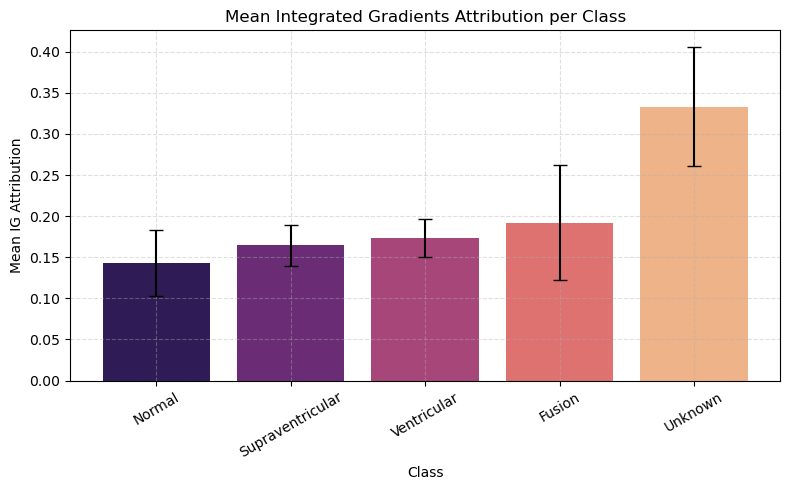

In [20]:
import seaborn as sns

def plot_ig_summary_bar(summary_df):
    plt.figure(figsize=(8, 5))
    # Assign x variable as hue and turn off legend
    sns.barplot(data=summary_df, x="Class", y="Mean IG Attribution", hue="Class", palette="magma", legend=False)
    
    # Add error bars manually
    plt.errorbar(
        x=range(len(summary_df)),
        y=summary_df["Mean IG Attribution"],
        yerr=summary_df["Std Dev"],
        fmt='none',
        c='black',
        capsize=5
    )

    plt.title("Mean Integrated Gradients Attribution per Class")
    plt.ylabel("Mean IG Attribution")
    plt.xlabel("Class")
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig("Mean IG Attribution.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_ig_summary_bar(summary_df)